<h2> <center> A few Machine Learning Methods for Trading </center> </h2>
<h3> <center> By Aman Jindal, CFA, FRM, CQF </center> </h3>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import datetime
import warnings
warnings.filterwarnings("ignore")

---
**Stocks Chosen:**

**The Home Depot, Inc.,  HD (NYSE)**
<br>
**Lowe's Companies, Inc., LOW (NYSE)**
<br><br>
Both Firms are Home Improvement Retailers based in US

In [2]:
# Importing Data

start = datetime.datetime(2014, 1, 1)
end   = datetime.datetime(2019, 12, 31)

df = yf.download('HD', start=start, end=end)
df1 = yf.download('LOW', start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


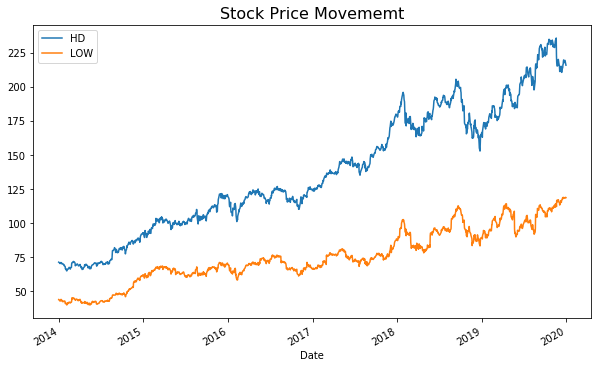

In [3]:
# Visualizing Stock Prices

plt.figure(figsize=(10,6))
df['Adj Close'].plot(label='HD')
df1['Adj Close'].plot(label='LOW')
plt.legend()
plt.title('Stock Price Movememt',fontsize=16)
plt.grid(False);

---
**10 Day Return Direction has been chosen for prediction**

In [4]:
# Creating Features

HD = df.copy()
LOW = df1.copy()
stocks = {'HD':HD,'LOW':LOW}

for stock in stocks.values():
    
    features = []
    stock.rename(columns={'Adj Close':'price'},inplace=True)
    stock['price_FD10'] = stock['price'].shift(-10)
    stock['ret_D10'] = np.log(stock['price']/stock['price'].shift(10))
    stock['ret_FD10'] = np.log(stock['price_FD10']/stock['price_FD10'].shift(10))
    stock['label'] = np.where(stock['ret_FD10']>=0,1,-1)
    
    for i in [10]:
        stock['ret_10Dlag'+ str(i)] = stock['ret_D10'].shift(i)
        features.extend(['ret_10Dlag'+str(i)])
    
    for i in [28]:
        stock['mom_D'+str(i)] = talib.MOM(stock['price'].values,timeperiod=i)
        features.extend(['mom_D'+str(i)])
    
    for i in [14,50,200]:
        stock['sma_D'+str(i)] = talib.SMA(stock['price'].values,timeperiod=i)
        stock['ema_D'+str(i)] = talib.EMA(stock['price'].values,timeperiod=i)
        stock['rsi_D'+str(i)] = talib.RSI(stock['price'].values,timeperiod=i)
        features.extend(['sma_D'+str(i),'ema_D'+str(i),'rsi_D'+str(i)])
    
    stock.dropna(inplace=True)

target_names = {-1:"Down Move",1:"Up Move"} 

In [5]:
# Feature Names
print(features)

['ret_10Dlag10', 'mom_D28', 'sma_D14', 'ema_D14', 'rsi_D14', 'sma_D50', 'ema_D50', 'rsi_D50', 'sma_D200', 'ema_D200', 'rsi_D200']


In [6]:
# Sanity Check

np.all(HD.index == LOW.index)

True

---
**Several functions have been defined below.These will be repeatedly called as we complete different tasks**

In [7]:
# Function for creating Train and Test Sets

def createTrainTest(stock, features, testSize = 252):
    
    totalRecords = len(stock.index)
    test = np.arange(totalRecords - testSize, totalRecords)
    train = np.arange(0,test[0])
    X_train = stock.loc[stock.index[train],features]
    X_test = stock.loc[stock.index[test],features]
    y_train = stock.loc[stock.index[train],'label']
    y_test = stock.loc[stock.index[test],'label']
    
    return X_train, X_test, y_train, y_test

In [8]:
# Function for Scaling Data

def scaleTrainTest(X_train, X_test):
    
    from sklearn.preprocessing import RobustScaler
    
    scaler = RobustScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [9]:
# Function for ConfusionMatrix, Precision-Recall Curve, Area under ROC Curve (Task B.1) 

def plotMetrics(clf, X_train, y_train, X_test, y_test, target_names, SVC_classifier=False):
    
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import plot_confusion_matrix
    from yellowbrick.classifier import PrecisionRecallCurve
    from yellowbrick.classifier import ROCAUC
    
    y_predicted = clf.predict(X_test)
    print('Precision Test Set: {:.2f}'.format(precision_score(y_test, y_predicted)))
    print('Recall Test Set: {:.2f}'.format(recall_score(y_test, y_predicted)))
    plot_confusion_matrix(clf, X_test, y_test, display_labels = target_names,cmap = plt.cm.Blues)
    plt.grid(False)
    
    plt.figure()
    viz1 = PrecisionRecallCurve(clf).fit(X_train,y_train)
    viz1.score(X_test, y_test)
    viz1.show()
    
    if SVC_classifier == False:
        viz2 = ROCAUC(clf, micro=False, macro=False).fit(X_train,y_train)
    else:
        viz2 = ROCAUC(clf, micro=False, macro=False, per_class=False).fit(X_train,y_train)
    viz2.score(X_test,y_test)
    viz2.show();
    

In [10]:
 # Function for Feature Scoring and Selection (Task B.2)

def featureImportances(X_train,y_train):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from yellowbrick.model_selection import FeatureImportances

    rfc = RandomForestClassifier(max_depth=3, n_jobs=-1,random_state=0)
    viz1 = FeatureImportances(rfc,relative=False,labels=features)
    viz1.fit(X_train, y_train)
    viz1.show()

    abc = AdaBoostClassifier(n_estimators=100,random_state=0)
    viz2 = FeatureImportances(abc,relative=False,labels=features)
    viz2.fit(X_train, y_train)
    viz2.show()

    gbc = GradientBoostingClassifier(max_depth=3,random_state=0)
    viz3= FeatureImportances(gbc,relative=False,labels=features)
    viz3.fit(X_train, y_train)
    viz3.show();

In [11]:
# Function for Plotting a Classifier (Task A.2 and Task A.3)


def plotClassRegions(clf, X_train, y_train, fig, subplot, X_test=None, y_test=None, title=None,target_names = None, 
                     axis_labels = None, plot_decision_regions = True):

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.colors import ListedColormap
     
    color_list_light = ['#FFFFAA','#AAAAFF']
    color_list_bold = ['#EEEE00','#0000CC']
    cmap_light = ListedColormap(color_list_light)
    cmap_bold  = ListedColormap(color_list_bold)

    h = 0.1
    k = 0.1
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50    

    x_min = X_train[:, 0].min()
    x_max = X_train[:, 0].max()
    y_min = X_train[:, 1].min()
    y_max = X_train[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, k))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    cs = subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)
    cbar = fig.colorbar(cs,ticks=[-1,0,1])
    cbar.ax.set_yticklabels(['-1', '0', '1'])
    subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)
    subplot.set_xlabel(axis_labels[0])
    subplot.set_ylabel(axis_labels[1])
    subplot.set_title(title,fontsize=16)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0,handles=legend_handles)

In [12]:
# Function for Plotting Transition Probabilities for Task B.3

def plotTransitionProb(clf,stock,X_test,y_test,title = None,testSize = 252):
    
    import matplotlib.pyplot as plt 
    import matplotlib.patches as mpatches
    from matplotlib.colors import ListedColormap
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    
    totalRecords = len(stock.index)
    test = np.arange(totalRecords - testSize, totalRecords)
    target_names = ['Wrong Prediction','Correct Prediction']
    c = y_test == clf.predict(X_test)
    color_list = ['#EEEE00','#0000CC']
    cmap = ListedColormap(color_list)
    legend_handles = []
    for i in range(0, len(target_names)):
        patch = mpatches.Patch(color=color_list[i], label=target_names[i])
        legend_handles.append(patch)

    plt.figure()
    plt.scatter(stock.index[test],clf.predict_proba(X_test)[:,1], c = c, cmap = cmap)
    plt.legend(loc=0,handles=legend_handles)
    plt.title('{}: Transition Probabilities for Up Moves'.format(title),fontdict = {'fontsize':16})

    plt.figure()
    plt.scatter(stock.index[test],clf.predict_proba(X_test)[:,0], c = c, cmap = cmap)
    plt.legend(loc=0,handles=legend_handles)
    plt.title('{}: Transition Probabilities for Down Moves'.format(title),fontdict = {'fontsize':16})

In [13]:
# Function for Calculating Daily Profit and Loss for Task B.3

def calcPnL(clf,stock,X_test,y_test,threshold = 0.5,testSize=252):
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    
    totalRecords = len(stock.index)
    test = np.arange(totalRecords - testSize, totalRecords)
    analysis = pd.DataFrame(data = HD.loc[HD.index[test],'ret_FD10'],index = HD.index[test])
    analysis['probUP'] = clf.predict_proba(X_test)[:,1]
    analysis['betSize'] = np.where(analysis['probUP']>threshold,2*analysis['probUP']-1,0.0)
    analysis['dailyP&L'] = analysis['ret_FD10']*analysis['betSize']
    profit = analysis['dailyP&L'].sum()*100
    return analysis['dailyP&L'], profit

---
### Logistic Regression with L2 Cost Function

**Logistic Regression:**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. The logistic function transforms real-valued input to an output number y between 0 and 1, interpreted as the probability the input object belongs to the positive class, given its input features.

$$ \hat{y} = logistic(\hat{b}+\hat{w_1}x_1+.......+\hat{w_n}x_n)$$

$$ = \frac{1}{1+exp[-(\hat{b}+\hat{w_1}x_1+.......+\hat{w_n}x_n)]} $$ 

Penalty L1 or L2 is applicable on the decision function inside the logistic function

**HD:**

1. Recall (0.81) is higer than Precision (0.64)
2. Quality of predicting down movements is low due to high False Postives
3. AUC (0.54) is slightly better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is relatively flat

**LOW:**

1. Recall (0.40) is lower than Precision (0.83)
2. Quality of predicting down movements is high due to low False Postives
3. AUC (0.70) is much better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

		Logisitic Classifier with L2 Penalty

		Analyzing HD

Accuracy training set: 0.64
Accuracy test set: 0.61
Precision Test Set: 0.64
Recall Test Set: 0.81


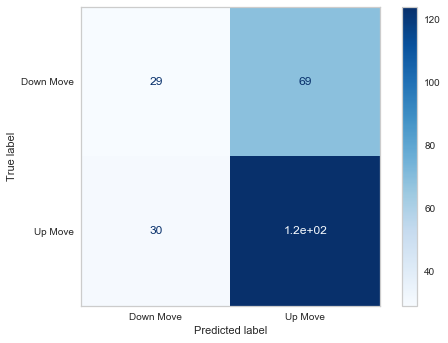

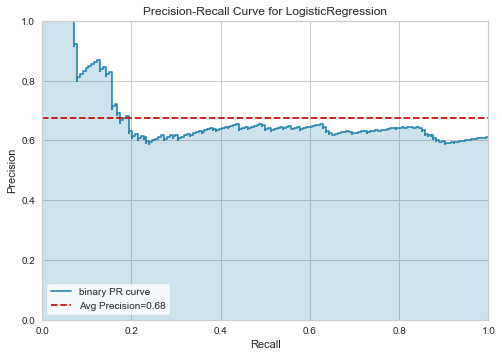

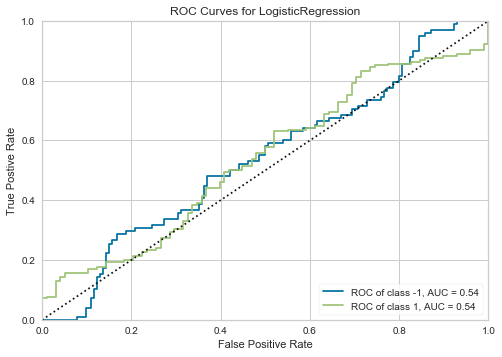


		Analyzing LOW

Accuracy training set: 0.62
Accuracy test set: 0.58
Precision Test Set: 0.83
Recall Test Set: 0.40


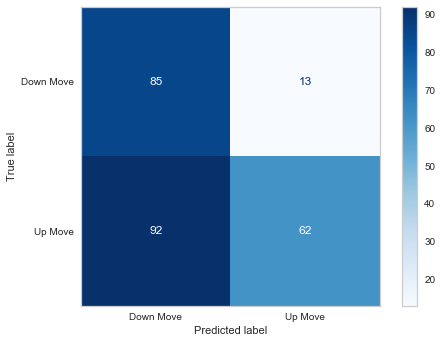

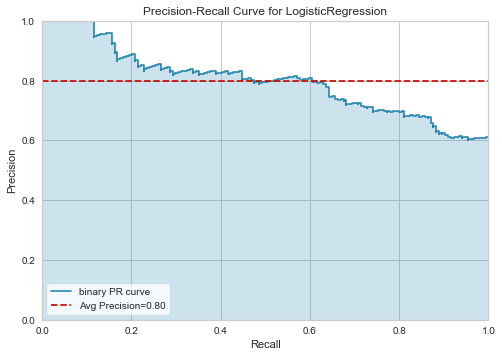

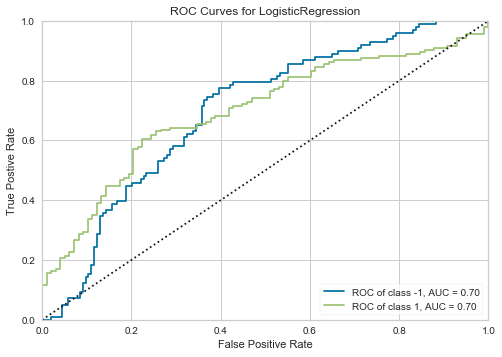

In [14]:
# Logistic Regression with penalty l2

print ("\033[1m\t\t\033[4mLogisitic Classifier with L2 Penalty\033[0m\033[0m")
from sklearn.linear_model import LogisticRegression
l2_coeff = np.zeros([len(stocks),len(features)])

for i, (stock_name, stock) in enumerate(stocks.items()):
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    clf = LogisticRegression(penalty = 'l2', C=1,random_state=0).fit(X_train_scaled, y_train)
    l2_coeff[i,:] = clf.coef_
    
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print('Accuracy training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
    print('Accuracy test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
    plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()), SVC_classifier=False)

---
### Logistic Regression with L1 Cost Function

**HD:**

1. Recall (0.81) is higer than Precision (0.64)
2. Quality of predicting down movements is low due to high False Postives
3. AUC (0.53) is slightly better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is relatively flat

**LOW:**

1. Recall (0.41) is lower than Precision (0.84)
2. Quality of predicting down movements is high due to low False Postives
3. AUC (0.70) is much better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

		Logisitic Classifier with L1 Penalty

		Analyzing HD

Accuracy training set: 0.64
Accuracy test set: 0.61
Precision Test Set: 0.64
Recall Test Set: 0.81


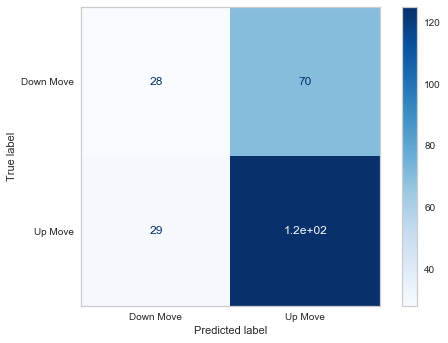

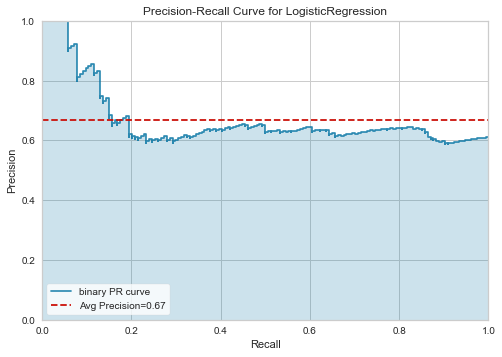

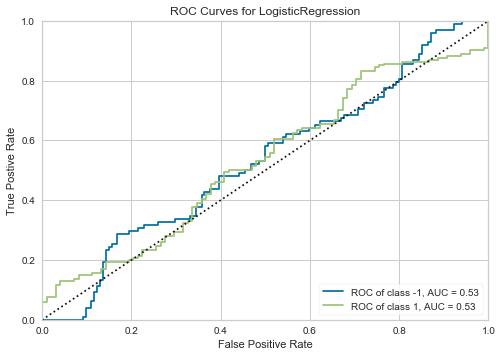


		Analyzing LOW

Accuracy training set: 0.63
Accuracy test set: 0.59
Precision Test Set: 0.84
Recall Test Set: 0.41


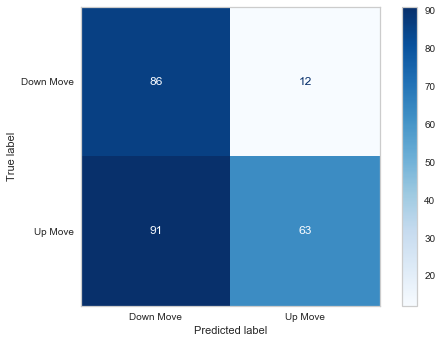

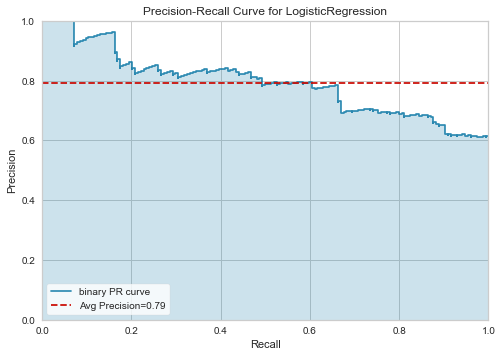

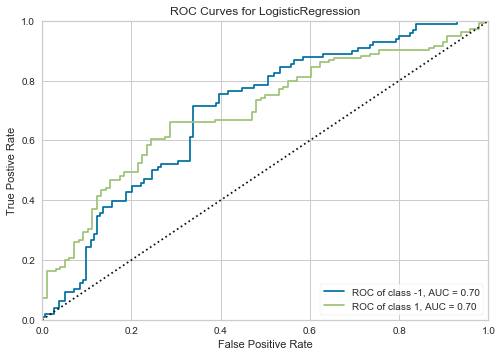

In [15]:
# Logistic Regression with penalty l1

print ("\033[1m\t\t\033[4mLogisitic Classifier with L1 Penalty\033[0m\033[0m")
from sklearn.linear_model import LogisticRegression
l1_coeff = np.zeros([len(stocks),len(features)])

for i, (stock_name, stock) in enumerate(stocks.items()):
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    clf = LogisticRegression(penalty = 'l1', solver='liblinear', C=1,random_state=0).fit(X_train_scaled, y_train)
    l1_coeff[i,:] = clf.coef_

    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print('Accuracy training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
    print('Accuracy test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
    plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()), SVC_classifier=False)

---
### L2 and L1 coefficients comparison

* L1 regularization minimizes the sum of the absolute values of the coefficients while L2 regularization minimizes the sum of squares of the coefficients. Thus, L1 has the effect of setting coefficeints to zero for less influential features. L2 also reduces the coefficients but they don't become zero as easily as in the case of L1 penalty. 

* In the table below we can see that for HD, 6 feautres have zero value for L1 penalty while no feature is zero for L2 penalty. L1 penalty yields a sparse solution and can also be used for feature selection.

* Thus, if we have many small to medium influential features, L2 penalty is preferred; and if we have a few large influential features, L1 penalty is preferred.

In [16]:
# Logistic Regression Comparing L2 and L1 Coefficients

pd.set_option("display.precision", 2)
for i, stock_name in enumerate(stocks): 
    print("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print(pd.DataFrame(np.vstack([l2_coeff[i,:],l1_coeff[i,:]]),index=['l2','l1'],
                       columns=features))                                     


		Analyzing HD

    ret_10Dlag10   mom_D28  sma_D14  ema_D14  rsi_D14  sma_D50  ema_D50  \
l2          0.47 -2.55e-03    -0.20    -0.17    -0.03    -0.16    -0.03   
l1          0.46  0.00e+00    -0.17     0.00     0.00    -0.17     0.00   

    rsi_D50  sma_D200  ema_D200  rsi_D200  
l2     0.53      0.13      0.07     -0.76  
l1     0.48      0.00      0.00     -0.76  

		Analyzing LOW

    ret_10Dlag10  mom_D28  sma_D14  ema_D14  rsi_D14  sma_D50  ema_D50  \
l2          0.18    -0.12    -1.01    -0.42    -0.48     0.05    -0.11   
l1          0.19    -0.08    -1.72     0.00    -0.59     0.00     0.00   

    rsi_D50  sma_D200  ema_D200  rsi_D200  
l2     1.65       1.2     -0.43     -0.77  
l1     1.78       1.0     -0.03     -0.75  


---
### Bayesian Classifier

**Naive Bayes Classifier:**

1. These classifiers are called 'Naive' because they assume that features are conditionally independent, given the class
2. They have highly efficient learning and prediction
3. Generalization performance may be worse than more sophisticated learning methods(as shown below)

**HD:**

1. Both Precision and Recall are zero. This is because the classifier has predicted all the returns as negative for the test set. Hence, the accuracy for the test set is also abysmal at 0.39. It wouldn't be advisable to use this classifier.
2. Quality of predicting down movements is high due to zero False Postives
3. AUC (0.62) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is moderately downward sloping

**LOW:**

1. Both Precision and Recall are zero. This is because the classifier has predicted all the returns as negative for the test set.Hence, the accuracy for the test set is also abysmal at 0.39. It wouldn't be advisable to use this classifier.
2. Quality of predicting down movements is high due to zero False Postives
3. AUC (0.62) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is moderately downward sloping


Analyzing HD

Accuracy training set: 0.59
Accuracy test set: 0.39
Precision Test Set: 0.00
Recall Test Set: 0.00


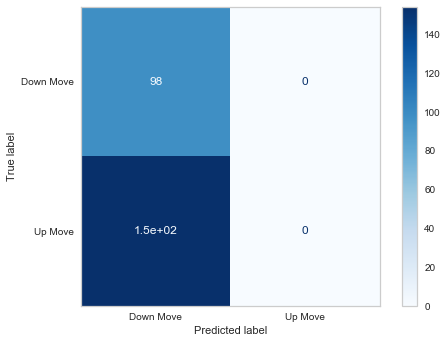

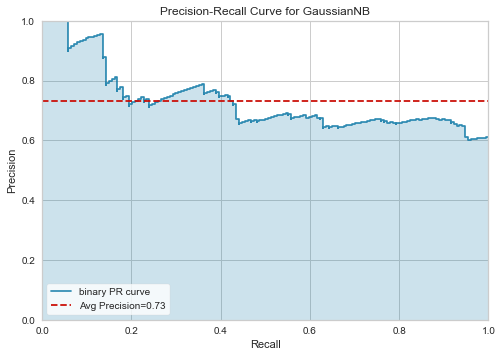

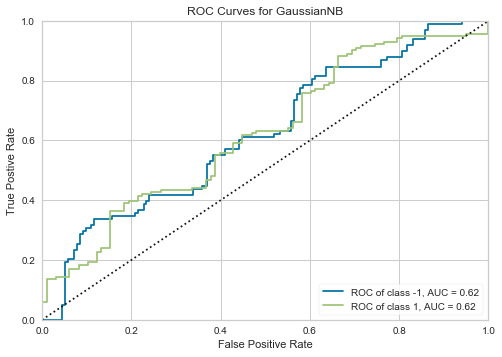


Analyzing LOW

Accuracy training set: 0.57
Accuracy test set: 0.39
Precision Test Set: 0.00
Recall Test Set: 0.00


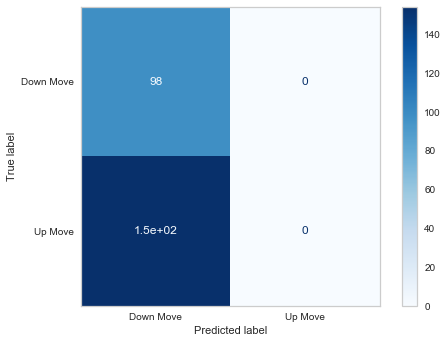

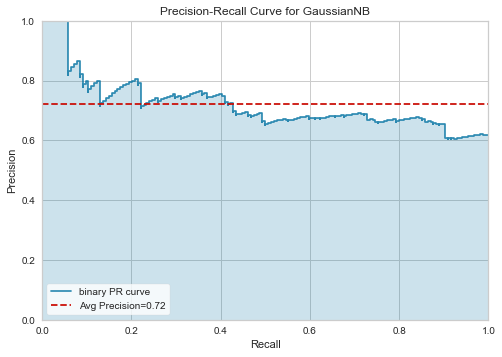

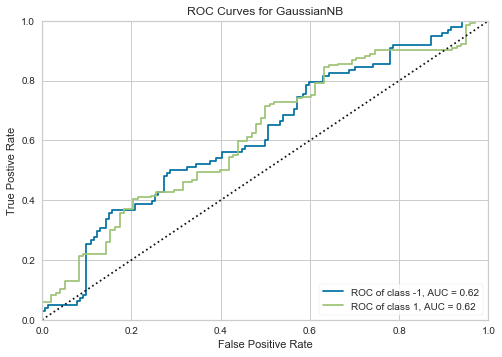

In [17]:
# Bayesian Classifier

from sklearn.naive_bayes import GaussianNB

for stock_name, stock in stocks.items():
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test) 
    clf = GaussianNB().fit(X_train_scaled, y_train)
    
    print ("\n\033[1m\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print('Accuracy training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
    print('Accuracy test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
    plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()), SVC_classifier=False)

---
### Use of K_Fold Corssvalidation and Reshuffled Samples

All three classifers have been considered viz. Logistic Regression with L2 penalty, Logistic Regression with L1 penalty and Bayesian Classifier

**Three types of Splitters have been implemented**:<br>
**1) KFold**<br>
**2) Shuffle Split**<br>
**3) Time Series Split**<br>

Time Series Split is the most appropriate as it makes sure that we are not using future data to predict past returns. Hence Time Series Split would also be used in GridSearchCV in Task B.2; Other two splitters are only for illustration purpose.

In [18]:
# K-Fold Cross Validation and Reshuffled Samples (Task A.1)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
np.set_printoptions(precision=2)

lrL2 = LogisticRegression(penalty = 'l2', C=1,random_state=0)
lrL1 = LogisticRegression(penalty = 'l1', solver='liblinear', C=1,random_state=0)
gnb = GaussianNB()

classifiers = {'Logistic Regression L2':lrL2, 'Logistic Regression L1':lrL1, 'Bayesian Classifier':gnb}

tss = TimeSeriesSplit(n_splits=3)
kfold = KFold(n_splits=3)
ss = ShuffleSplit(n_splits=3)

splitTypes = {'Time Series Split': tss, 'K Fold Split':kfold, 'Shuffle Split': ss}

for stock_name, stock in stocks.items():
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test) 
    
    for classifier_name, clf in classifiers.items():
        print ("\n\033[1m\t\033[4m{}\033[0m\033[0m\n".format(classifier_name))
        
        for split_name, split in splitTypes.items():
            print ("\033[1m\033[4m{}\033[0m\033[0m".format(split_name))
            cv_results = cross_validate(clf,X_train_scaled,y_train,cv=split,n_jobs=-1)
            print('Test Scores Across Folds:{}'.format(cv_results['test_score']))
            print('Mean Test Score: {:.2f}\n'.format(cv_results['test_score'].mean()))
    


		Analyzing HD

	Logistic Regression L2

Time Series Split
Test Scores Across Folds:[0.69 0.39 0.48]
Mean Test Score: 0.52

K Fold Split
Test Scores Across Folds:[0.71 0.59 0.41]
Mean Test Score: 0.57

Shuffle Split
Test Scores Across Folds:[0.63 0.62 0.68]
Mean Test Score: 0.64


	Logistic Regression L1

Time Series Split
Test Scores Across Folds:[0.63 0.4  0.48]
Mean Test Score: 0.51

K Fold Split
Test Scores Across Folds:[0.71 0.59 0.41]
Mean Test Score: 0.57

Shuffle Split
Test Scores Across Folds:[0.64 0.55 0.63]
Mean Test Score: 0.61


	Bayesian Classifier

Time Series Split
Test Scores Across Folds:[0.52 0.3  0.53]
Mean Test Score: 0.45

K Fold Split
Test Scores Across Folds:[0.51 0.59 0.44]
Mean Test Score: 0.51

Shuffle Split
Test Scores Across Folds:[0.61 0.59 0.51]
Mean Test Score: 0.57


		Analyzing LOW

	Logistic Regression L2

Time Series Split
Test Scores Across Folds:[0.61 0.59 0.46]
Mean Test Score: 0.55

K Fold Split
Test Scores Across Folds:[0.49 0.56 0.47]
Mean Tes

---
### SVM Classifier Soft Margin

**HD:**

1. Recall (0.43) is lower than Precision (0.74)
2. Quality of predicting down movements is moderately good due to low False Postives
3. AUC (0.68) is much better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

**LOW:**

1. Recall (0.61) is lower than Precision (0.69)
2. Quality of predicting down movements is low due high False Postives
3. AUC (0.60) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is moderately downward sloping



Analyzing HD

Accuracy training set: 0.71
Accuracy test set: 0.56
Precision Test Set: 0.74
Recall Test Set: 0.43


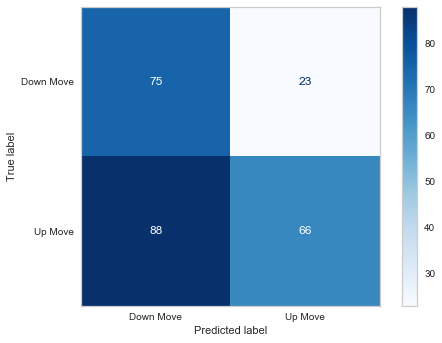

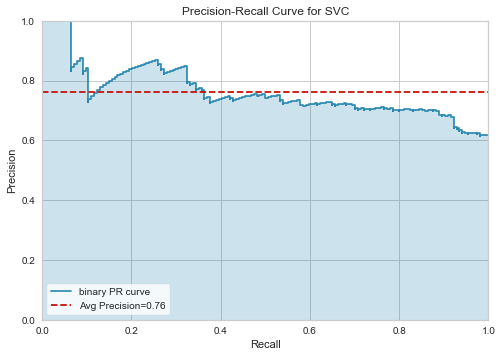

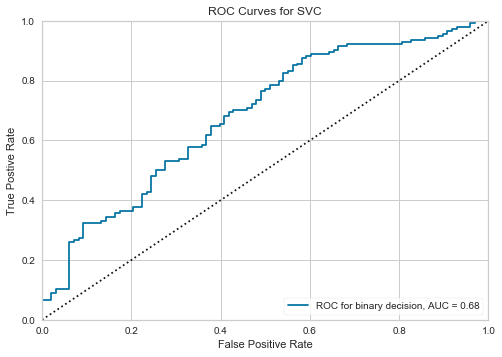


Analyzing LOW

Accuracy training set: 0.71
Accuracy test set: 0.59
Precision Test Set: 0.69
Recall Test Set: 0.61


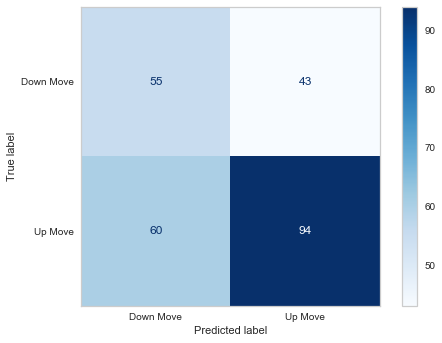

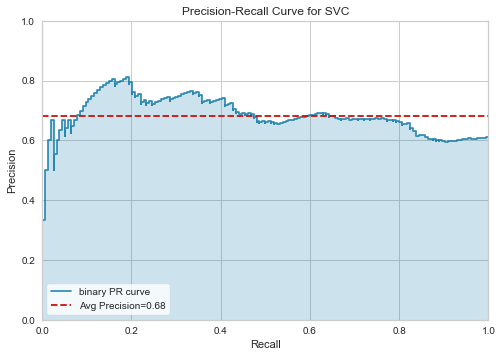

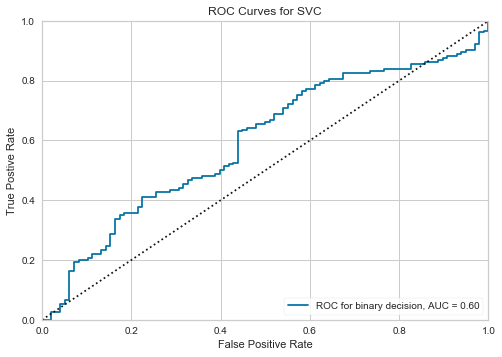

In [19]:
# SVM Classifier Soft Margin

from sklearn.svm import SVC

for stock_name, stock in stocks.items():
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test) 
    clf = SVC(kernel='rbf',C=1,gamma='auto',random_state=0).fit(X_train_scaled, y_train)
    
    print ("\n\033[1m\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print('Accuracy training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
    print('Accuracy test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
    plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()), SVC_classifier=True)


---
### SVM Classifier, Hard Margin

**HD:**

1. Recall (0.38) is much lower than Precision (0.88). However, the classifier has predicted very few positives
2. Quality of predicting down movements is good due to low False Postives
3. AUC (0.64) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

**LOW:**

1. Recall (0.21) is much lower than Precision (0.50). Howver, both the metrics are bad. Accuracy is an abysmal 0.39. This classifier shouldn't be used. Overfitting due to Hard Margins is unsatisfactory.
2. Quality of predicting down movements is low due high False Postives
3. AUC (0.39) is even worse than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is flat


Analyzing HD

Accuracy training set: 0.88
Accuracy test set: 0.56
Precision Test Set: 0.81
Recall Test Set: 0.38


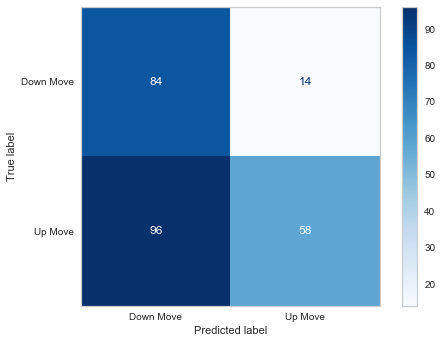

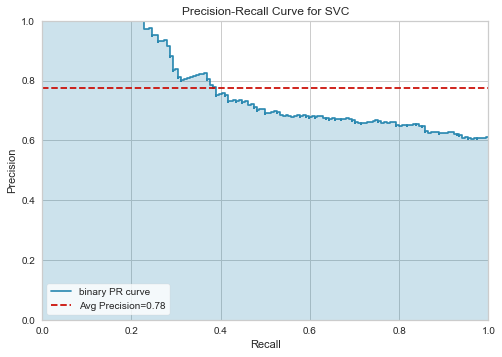

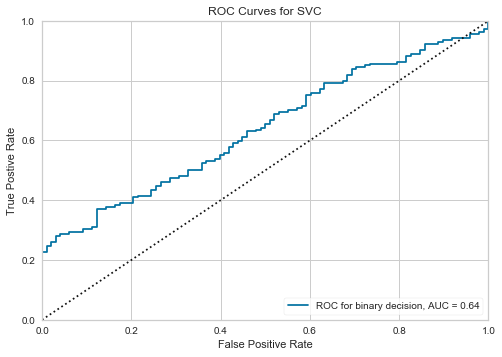


Analyzing LOW

Accuracy training set: 0.92
Accuracy test set: 0.39
Precision Test Set: 0.50
Recall Test Set: 0.21


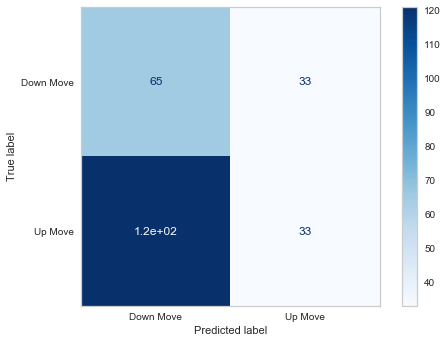

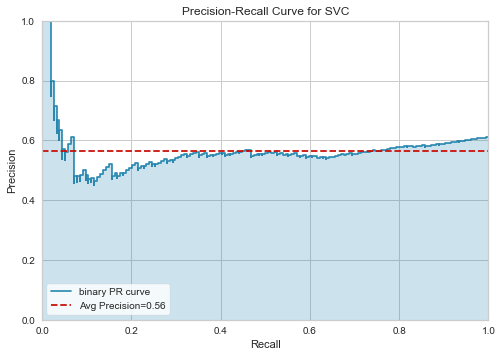

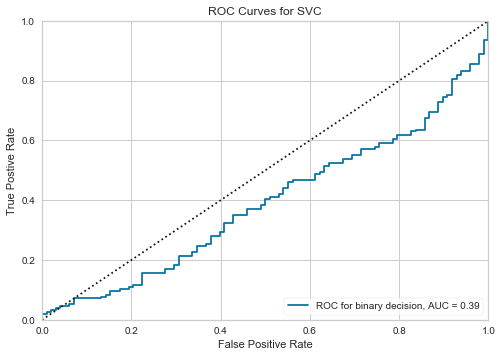

In [20]:
# SVM Classifier Hard Margin

from sklearn.svm import SVC

for stock_name, stock in stocks.items():
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test) 
    clf = SVC(kernel='rbf',C=1000,gamma='auto',random_state=0).fit(X_train_scaled, y_train)
    
    print ("\n\033[1m\033[4mAnalyzing {}\033[0m\033[0m\n".format(stock_name))
    print('Accuracy training set: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
    print('Accuracy test set: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
    plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()), SVC_classifier=True)


---
### Plotting SVM Classifier for Return vs Momentum Features (Both Soft and Hard Margin SVM)


Support Vectors are those datapoints that the Classifier Margin pushes up against. Thus, once support vectors are identified, the other training examples can be ignored for classification purpose.

**Hard Margin:** 
* Hard Margins imply that we classify all training examples 100% correctly. This may however result in over-fitting and less-smooth decision boundaries and thus the classifier may have poor generalization ability.

* Hence, our job is to find the coefficient vector w and constant b, such that

$\quad\quad \Phi(w) = 0.5w^Tw \quad $is minimized<br><br>
$\quad$ and for all $\quad (x_i,y_i): y_i(w^Tx_i+b) \geq 1 $ <br><br>
    
**Soft Margins:**
*  The data might not be linearly separable. Thus we allow for slack variables $\epsilon_i$ in our objective function to allow for possible miscalssification of difficult or noisy examples. This may lead to smoother boundaries and less overfitted models and consequently a better generalization ability.

* Hence, our job is to find the coefficient vector w and constant b, such that

$\quad\quad \Phi(w) = 0.5w^Tw + \lambda\sum \epsilon_i\quad$is minimized<br><br>
$\quad$ and for all $\quad (x_i,y_i): y_i(w^Tx_i+b) \geq 1 - \epsilon_i $ <br><br>
$\quad$ and $\quad\epsilon_i\geq0 $


We can see the impact of Soft and Hard Margins in the plots below. The classfier boundaries have been plotted and then Test Set Data has been plotted. For both the companies, Hard Margin SVM Classifiers (High value of C = 1000) result in more complex boundary surfaces and are not good at generalization to the Test Set as evident form a lot of miscalssified points.
Soft Margin SVM Classifiers (Low value of C = 1) result in smoother boundaries. Although the predictions are not good for Soft Margins as well. 
<br><br>
Poor Prediction for both Hard and Soft Margins is in part due to the two features chosen (Return and Momentum) which are not very informative by themselves.

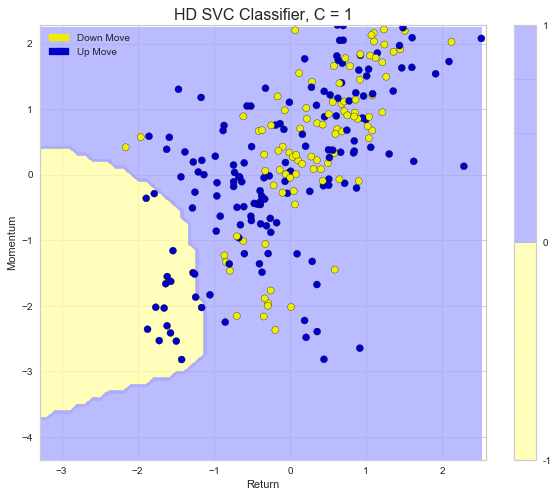

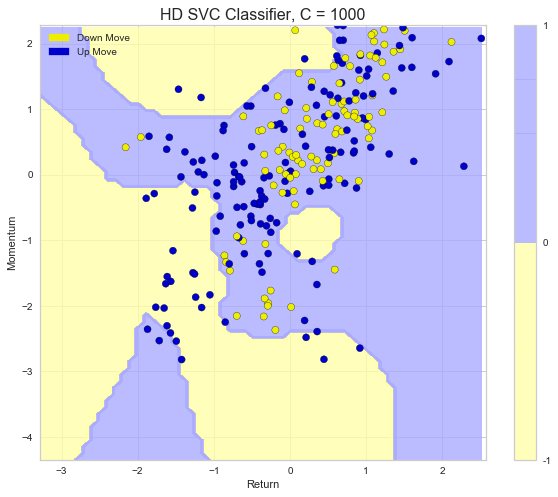

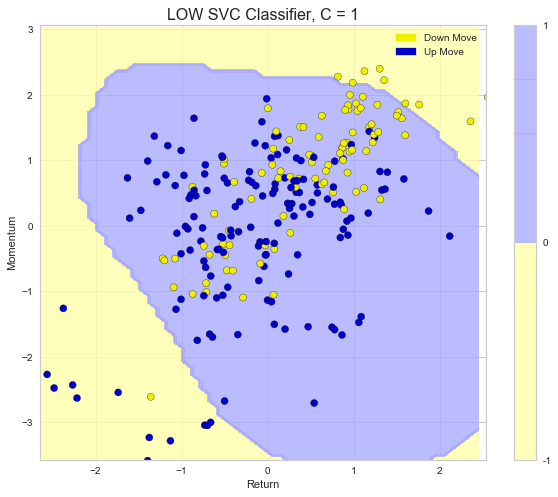

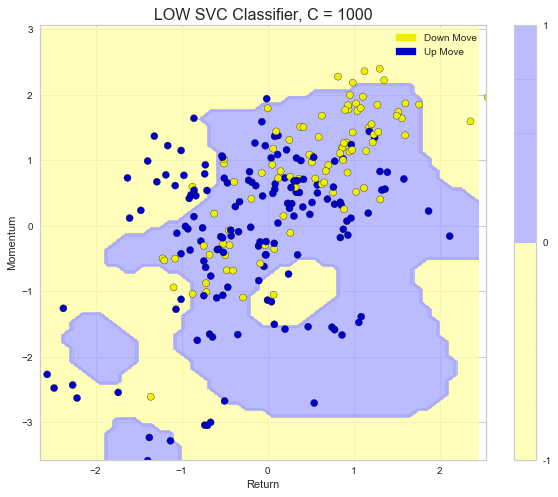

In [21]:
# SVC Plotting Momentum vs Return Feature

from sklearn.svm import SVC

for stock_name, stock in stocks.items():    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    X_train_scaled_C2 = X_train_scaled[:,(0,1)]
    X_test_scaled_C2 = X_test_scaled[:,(0,1)]
    axis_labels = ['Return','Momentum']
    
    for i in [1,1000]:
        clf = SVC(kernel='rbf',C=i,gamma='auto',random_state=0).fit(X_train_scaled_C2, y_train)
        fig, subplot = plt.subplots(figsize=(10,8)) 
        title = '{} SVC Classifier, C = {}'.format(stock_name,i)
        plotClassRegions(clf, X_train_scaled_C2, y_train, fig, subplot, X_test=X_test_scaled_C2, 
                                          y_test=y_test, title=title, target_names = list(target_names.values()),
                                          axis_labels=axis_labels,plot_decision_regions = True)

### K-NN Classifier (Manhattan, Euclidean and Mahalanobis Distance Metrics)

**K-NN Classfier:**<br>

Given a training set X_train with labels y_train, and given a new instance x_test, it can be classified using K-NN classifier as:

1. Find the most similar instances (let's call them X_NN) to x_test that are in X_train
2. Get the labels y_NN for the instances in X_NN
3. Predict the label for x_test by combining the labels y_NN e.g. by simple majority vote
4. Higher the count of X_NN (n_neighbours) chosen, the more smoother are the decision boundaries
<br>

The similar instances (X_NN) to x_test are found out by calculating distance of this point from all the points in the training set. The distance metrics are:

* **Manhattan:**<br>
It is the Minkowski 1-norm distance. For two points $x_i$ and $y_i$, it can be calculated as:
$$ \sum_{i=1}^{n} |x_i - y_i| $$

**HD:**

1. Recall (0.72) is similar to Precision (0.66)
2. Quality of predicting down movements is bad due to high False Postives
3. AUC (0.58) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

**LOW:**

1. Recall (0.53) is lower than Precision (0.76)
2. Quality of predicting down movements is okay due to realtively low False Postives
3. AUC (0.61) is even worse than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is flat with a few steps

* **Euclidean:**<br>
It is the Minkowski 2-norm distance. For two points $x_i$ and $y_i$, it can be calculated as:
$$ \sqrt{\sum_{i=1}^{n} {|x_i - y_i|}^2} $$

**HD:**

1. Recall (0.78) is better than Precision (0.69)
2. Quality of predicting down movements is bad due to high False Postives
3. AUC (0.62) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is downward sloping

**LOW:**

1. Recall (0.70) is similar to Precision (0.66)
2. Quality of predicting down movements is bad due to high False Postives
3. AUC (0.53) is similar to the AUC of 45 degrees line (0.5)
4. Precision Recall curve is flat

* **Mahalanobis:**<br>
Mahalanobis distance, or the "generalized squared interpoint distance" is defined as a dissimilarity measure between two points of the same distribution with the covariance matrix S. It can be calculated as: 

$$ \sqrt{(x-y)^TS^{-1}(x-y)} $$


**HD:**

1. Recall (0.84) is better than Precision (0.69). Both the metrics are high as compared to other classfiers
2. Quality of predicting down movements is bad due to high False Postives
3. AUC (0.65) is better than the AUC of 45 degrees line (0.5)
4. Precision Recall curve is flat

**LOW:**

1. Recall (0.95) is much better than Precision (0.65)
2. Quality of predicting down movements is very bad due to high False Postives
3. AUC (0.52) is similar to the AUC of 45 degrees line (0.5)
4. Precision Recall curve is flat
<br>

**K-NN CLassifier is lazy:**

In machine learning, lazy learning is a learning method in which generalization of the training data is, in theory, delayed until a query is made to the system, as opposed to in eager learning, where the system tries to generalize the training data before receiving queries.

K-NN is a lazy learner because it doesn't learn a discriminative function from the training data but memorizes the training dataset instead. Hence, the training time is brief in K-NN because the algorithm has to merely memorize all the examples. However, prediction step in K-NN is relatively expensive: Each time we want to make a prediction, we have to search for the nearest neighbors in the entire training set.
<br><br>


		Analyzing HD

	manhattan

Number of Neighbours for Max Test Score:90
Accuracy training set: 0.67
Accuracy test set: 0.61

Precision Test Set: 0.66
Recall Test Set: 0.72


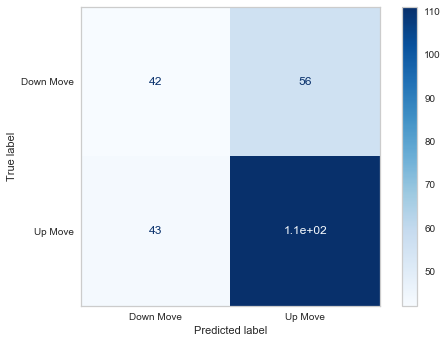

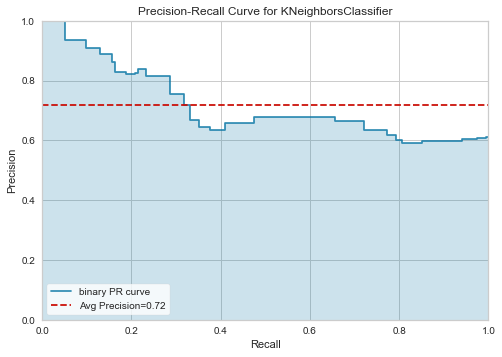

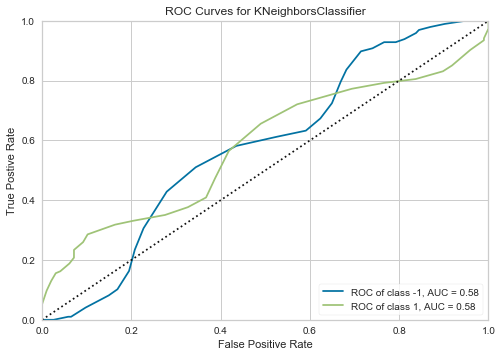


	euclidean

Number of Neighbours for Max Test Score:67
Accuracy training set: 0.70
Accuracy test set: 0.65

Precision Test Set: 0.69
Recall Test Set: 0.78


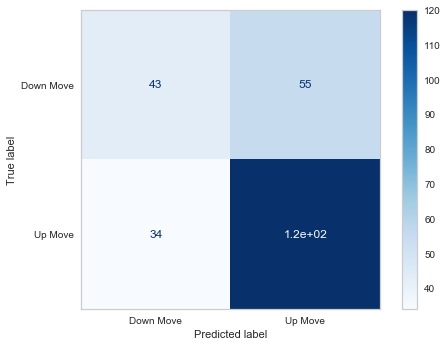

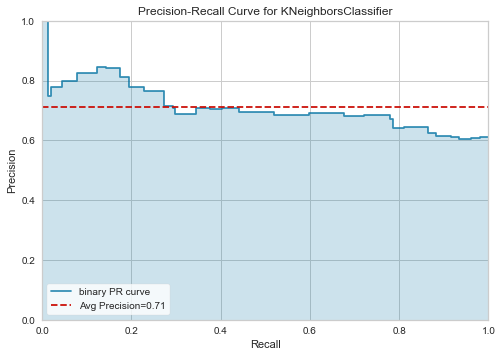

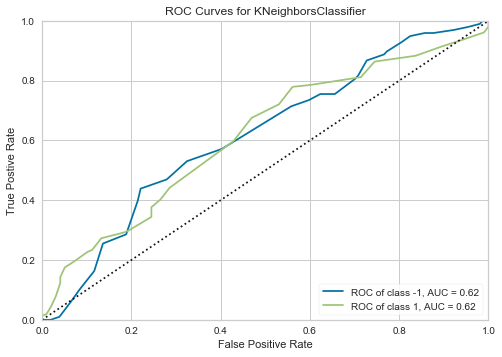


	mahalanobis

Number of Neighbours for Max Test Score:10
Accuracy training set: 0.87
Accuracy test set: 0.67

Precision Test Set: 0.69
Recall Test Set: 0.84


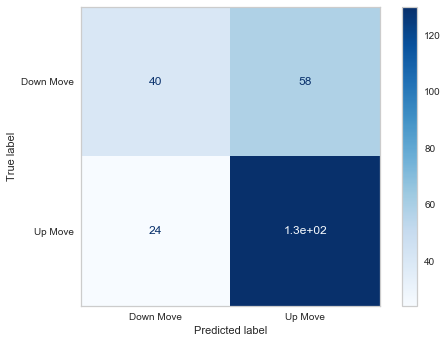

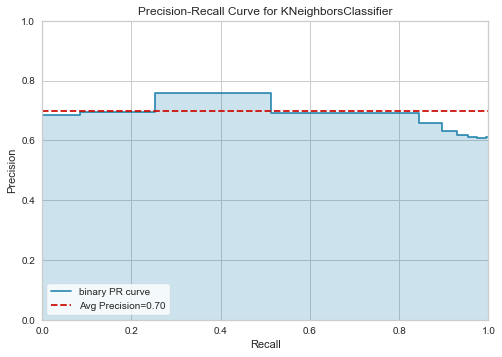

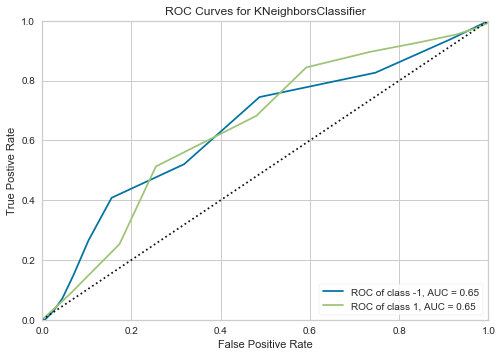


		Analyzing LOW

	manhattan

Number of Neighbours for Max Test Score:9
Accuracy training set: 0.88
Accuracy test set: 0.61

Precision Test Set: 0.76
Recall Test Set: 0.53


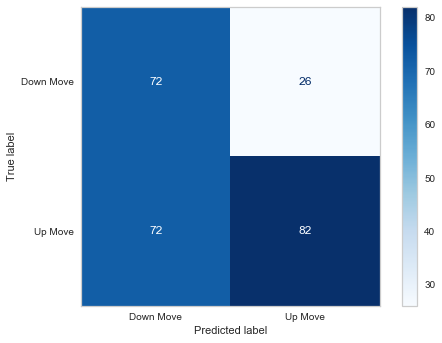

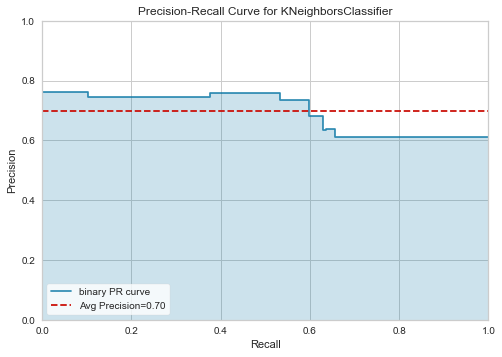

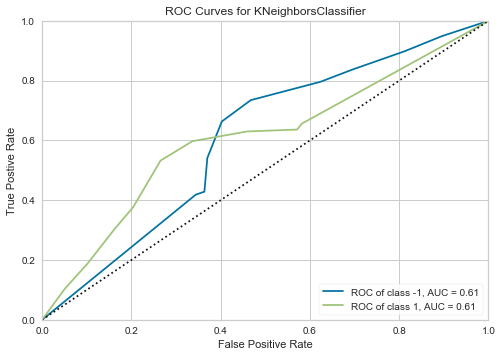


	euclidean

Number of Neighbours for Max Test Score:83
Accuracy training set: 0.64
Accuracy test set: 0.60

Precision Test Set: 0.66
Recall Test Set: 0.70


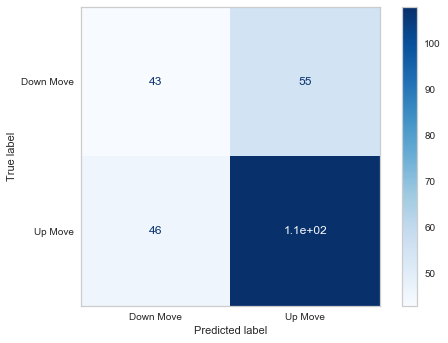

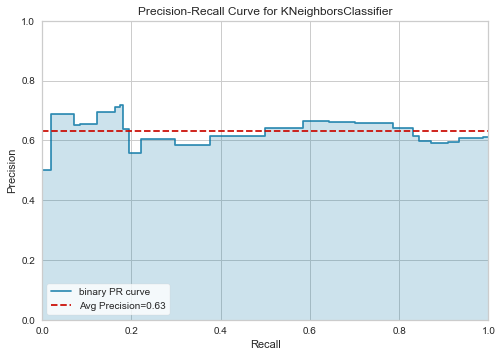

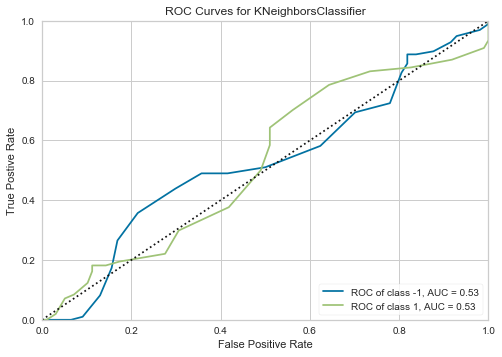


	mahalanobis

Number of Neighbours for Max Test Score:90
Accuracy training set: 0.65
Accuracy test set: 0.65

Precision Test Set: 0.65
Recall Test Set: 0.95


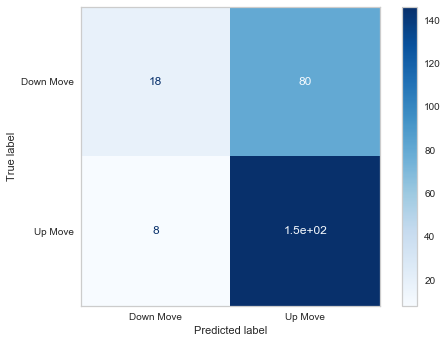

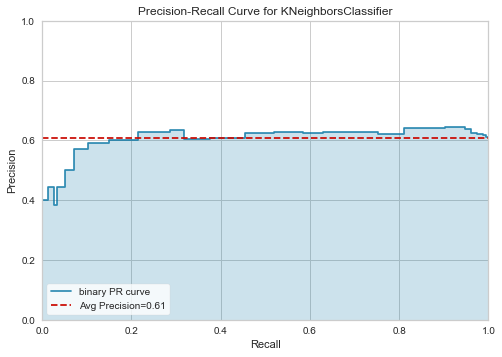

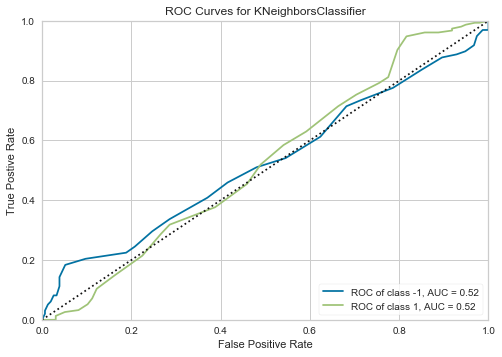

In [22]:
# K-NN Classifier Manhattan, Euclidean and Mahalanobis

from sklearn.neighbors import KNeighborsClassifier

metrics = ['manhattan','euclidean','mahalanobis']
best_neighbour_count = {'HD':[],'LOW':[]}

for stock_name, stock in stocks.items():
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
     
    for metric in metrics:
        print ("\n\033[1m\t\033[4m{}\033[0m\033[0m\n".format(metric))
        scores = []
        for i in range(1,101):
            if metric == 'mahalanobis':
                knn = KNeighborsClassifier(n_neighbors = i, algorithm='brute', metric=metric,
                           metric_params={'V' : np.cov(X_train_scaled)},n_jobs=-1).fit(X_train_scaled,y_train)
            else:
                knn = KNeighborsClassifier(n_neighbors = i, metric=metric, n_jobs=-1).fit(X_train_scaled,y_train) 
            scores.append(knn.score(X_test_scaled, y_test))

        n_neighbors = scores.index(max(scores))+1  # Number of Neighbours corresponding to Maximum Test Score
        best_neighbour_count[stock_name].append(n_neighbors)                                                                                  
        if metric == 'mahalanobis':
                knn = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm='brute', metric=metric,
                           metric_params={'V' : np.cov(X_train_scaled)},n_jobs=-1).fit(X_train_scaled,y_train)
        else:
                knn = KNeighborsClassifier(n_neighbors = n_neighbors, metric=metric, n_jobs=-1).fit(X_train_scaled,y_train)                                                                                   
                                                                                          
        print('Number of Neighbours for Max Test Score:{}'.format(n_neighbors))
        print('Accuracy training set: {:.2f}'.format(knn.score(X_train_scaled, y_train)))
        print('Accuracy test set: {:.2f}\n'.format(knn.score(X_test_scaled, y_test)))
        plotMetrics(knn, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()))

---
### Plotting Decision boundaries for K-NN

We can observe that as number of n-neighbours increase, the decision boundaries become smoother. This is because, the ability of an outlier/single example to influence the prediction is reduced. A larger number of examples vote on predicting the class. Hence, the prediction tends to get averaged out and thus resulting in smoother decision boundaries.

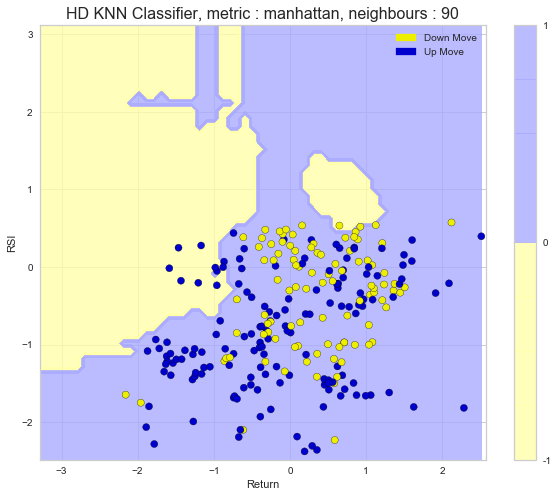

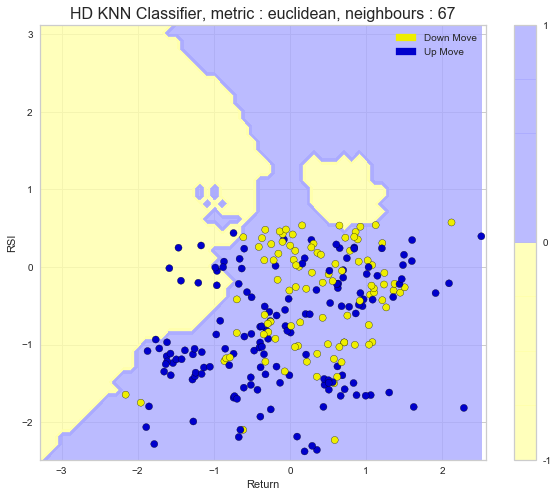

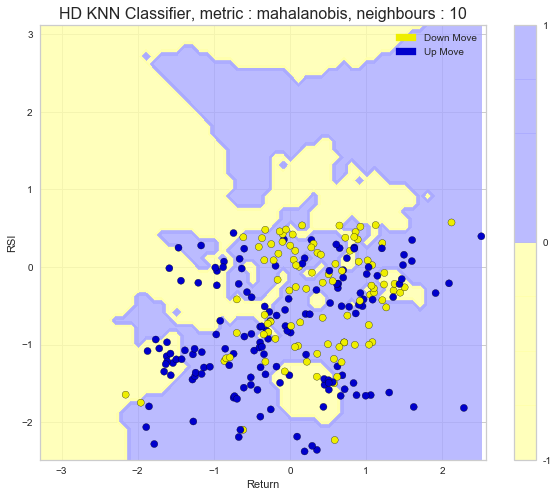

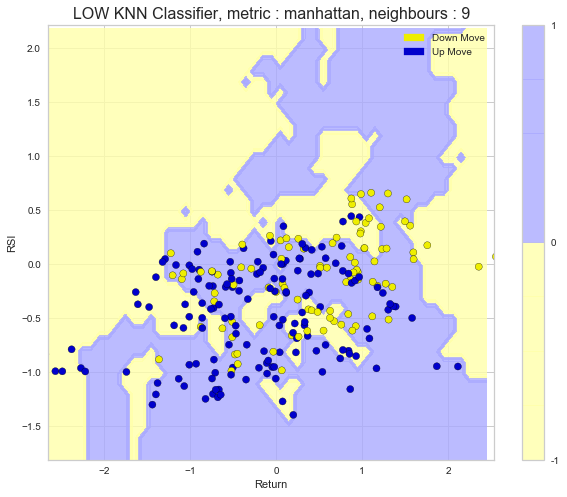

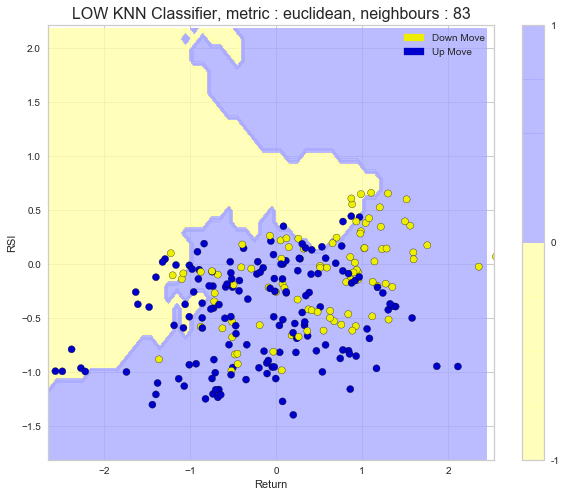

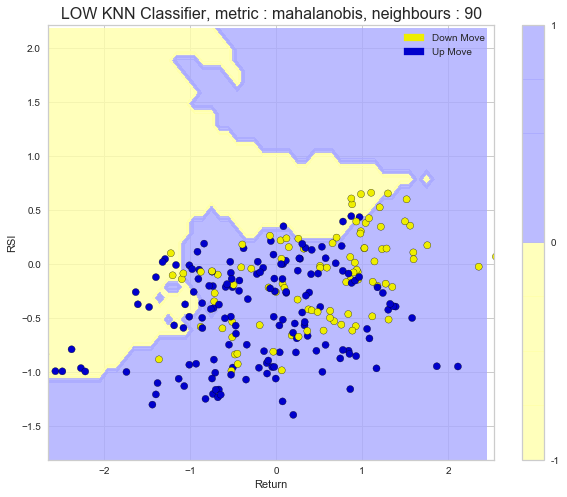

In [23]:
# K-NN Classifier Manhattan, Euclidean and Mahalanobis (Plotting Decision Boundaries) Return vs RSI Features

from sklearn.neighbors import KNeighborsClassifier

metrics = ['manhattan','euclidean','mahalanobis']

for stock_name, stock in stocks.items():    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    X_train_scaled_C2 = X_train_scaled[:,(0,10)]
    X_test_scaled_C2 = X_test_scaled[:,(0,10)]
    axis_labels = ['Return','RSI']
    
    for i, metric in enumerate(metrics):
        if metric == 'mahalanobis':
                knn = KNeighborsClassifier(n_neighbors = best_neighbour_count[stock_name][i], algorithm='brute',
                                           metric=metric, metric_params={'V' : np.cov(X_train_scaled)},
                                           n_jobs=-1).fit(X_train_scaled_C2,y_train)
        else:
                knn = KNeighborsClassifier(n_neighbors = best_neighbour_count[stock_name][i], metric=metric,
                                           n_jobs=-1).fit(X_train_scaled_C2,y_train) 
        
        fig, subplot = plt.subplots(figsize=(10,8)) 
        title = '{} KNN Classifier, metric : {}, neighbours : {}'.format(stock_name,metric,best_neighbour_count[stock_name][i])
        plotClassRegions(knn, X_train_scaled_C2, y_train, fig, subplot, X_test=X_test_scaled_C2, 
                                          y_test=y_test, title=title, target_names = list(target_names.values()),
                                          axis_labels=axis_labels,plot_decision_regions = True)

---
### Feature Scoring or Selection

Feature importances have been plotted using the following three classifiers:
1. Random Forest Classifier
2. Ada Boost Classifier
3. Gradient Boosting Classifier

Observations (for both HD and LOW):
1. None of the features have very high importance. The maximum importance seen is around 0.20
2. Longer term features such as RSI 200 Days, SMA 200 Days have higher importances
3. SMA feautres tend to have higher importances
4. Momentum and Return Features tend to have lower importances

All the features will be retained, as none of the features have very high importance and the difference between high and low ranking features is not pronounced. 


		Analyzing HD


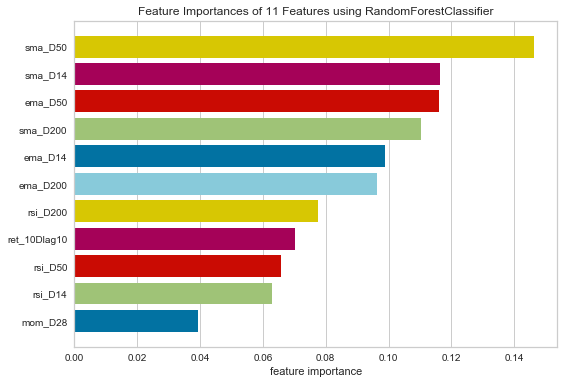

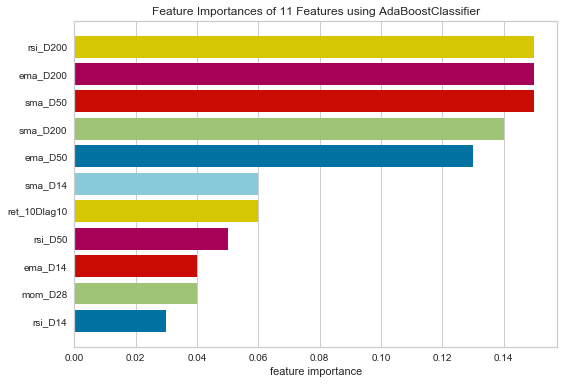

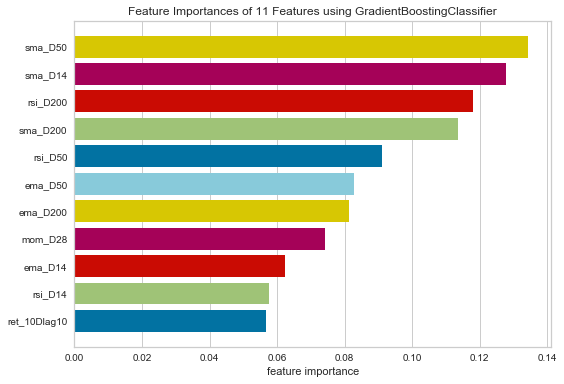


		Analyzing LOW


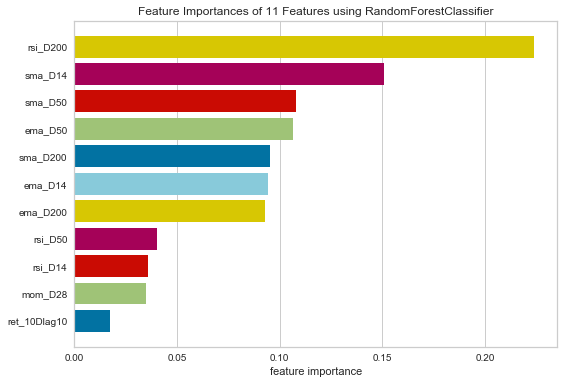

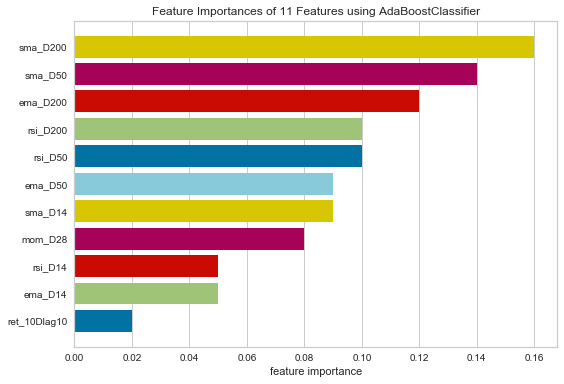

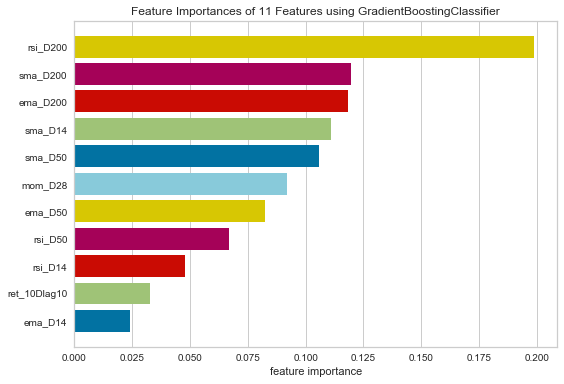

In [24]:
# Feature Scoring or Selection (Task B.2):

for stock_name, stock in stocks.items():
    
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    featureImportances(X_train_scaled,y_train)

---
### Parameter Tuning using GridSearch CV for all the classifiers

**Parameter Tuning has been done as follows:**

1. Logistic Regression L2 and L1 Penalty for parameter C (Higher the C less the Regularization and more the Complexity).
2. Support Vector Classifier for parameter gamma (gamma is the kernel width parameter for a RBF Kernel. Higher the gamma less the Regularization and more the Complexity)
3. K-NN (Manhattan, Euclidean and Mahalanobis) for parameter n_neighbours (Higher the count of n_neighbours, smoother the decision boundaries)
4. Area Under the Receiver Operating Characteristic Curve (roc_auc) has been chosen as the scoring parameter for GridSearchCV
5. 3 Fold Time Series Split has been chosen as the Cross Validation(cv) parameter for GridSearchCV
6. For both the stocks, each classifier's best estimate classifier is stored and the AUC Score on Training set and Accuracy Score for the Test Set are presented for comparisons and selection.

On the basis of the results, for both the stocks, **Logistic Regression L2 Penalty classifier and K-NN Mahalanobis Metric classifier** are chosen for return prediction in Task B.3

**How to reduce misclassified negative returns:**

1. Misclassified Negative returns are those negative returns that have been incorrectly classified as positive. Thus, they are "False Postives" or represent Type 1 Error. The metric that most directly accounts for False Positives is Precision. Higher the Precision, lower the False Positives.
2. To reduce False Positives, we can tune the parameters of our model using 'precision' as the scoring metric. GridSearchCV would look for parameters such that Precision is maximized.
3. Another way to reduce False Positives, is to raise the decision threshold. Thus, only those predictions that have a higher probability of being Positive will be classified as Positive. The borderline examples or examples with probabilities slightly tilting towards the positive side, will be classified as negative. However, we shouldn't increase the decision threshold so much such that very few examples are classified as positive.
4. Precision Recall Curve as plotted in Task B.1 help us visualize how Precision and Recall vary as Decision Threshold changes. We can choose the decision threshold level as per our Precision requirement.
5. F1 score is a composite score of Precsion and Recall. We can use a lower value of beta in F1 score metric to make F1 score more precision oriented. Hence, if F1 score is used as a scoring metric, we can orient the F1 score to be more precision oriented to reduce False Positives.


In [25]:
# Parameter Tuning using GridSearchCV for all Classifiers (Task B.2)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

bestClassifiers = {'HD':[],'LOW':[]}
tss = TimeSeriesSplit(n_splits=3)
lrcL2 = LogisticRegression(random_state = 0, n_jobs = -1, max_iter = 1000)
lrcL1 = LogisticRegression(penalty = 'l1', solver='liblinear',random_state=0, max_iter = 1000, tol = 0.01)
svc = SVC(kernel ='rbf',random_state = 0)
knn = KNeighborsClassifier(n_jobs = -1)
classifiers = {'Logistic Regression L2': lrcL2, 'Logistic Regression L1': lrcL1, 
               'SVC': svc,'KNN': knn,'KNN Mahalanobis': np.nan}

c = list(np.linspace(0.1,0.99,10))+list(np.arange(1,101,5))
gamma = list(np.linspace(0.01,0.099,10))+list(np.linspace(0.1,0.99,10))+list(np.arange(1,100,5))
n_neighbors = list(np.arange(1,101))

lrcL2_grid_values = {'C': c}
lrcL1_grid_values = {'C': c}
svc_grid_values = {'gamma': gamma}
knn_grid_values = {'n_neighbors':n_neighbors,'metric':['manhattan','euclidean']}
knn_mahalanobis_grid_values = {'n_neighbors':n_neighbors}
grid_values = [lrcL2_grid_values,lrcL1_grid_values,svc_grid_values,knn_grid_values,knn_mahalanobis_grid_values]

for stock_name, stock in stocks.items():
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    knn_mahalanobis = KNeighborsClassifier(algorithm='brute', metric = 'mahalanobis',
                               metric_params={'V' : np.cov(X_train_scaled)},n_jobs=-1)
    classifiers['KNN Mahalanobis'] = knn_mahalanobis 
    
    for (classifier_name, clf), param_grid in zip(classifiers.items(),grid_values):
        print ("\n\033[1m\033[4m{}\033[0m\033[0m".format(classifier_name))
        grid_clf = GridSearchCV(clf, param_grid = param_grid, n_jobs = -1, cv = tss, scoring = 'roc_auc')    
        grid_clf.fit(X_train_scaled, y_train)
        clf_best = grid_clf.best_estimator_
        bestClassifiers[stock_name].append(clf_best)
        
        print('Grid best parameters: {}'.format(grid_clf.best_params_))
        print('Grid best AUC: {:.2f}'.format(grid_clf.best_score_))
        print('Test set Accuracy: {:.2f}'.format(clf_best.score(X_test_scaled, y_test)))



		Analyzing HD

Logistic Regression L2
Grid best parameters: {'C': 0.1}
Grid best AUC: 0.68
Test set Accuracy: 0.58

Logistic Regression L1
Grid best parameters: {'C': 0.2977777777777778}
Grid best AUC: 0.68
Test set Accuracy: 0.59

SVC
Grid best parameters: {'gamma': 0.1988888888888889}
Grid best AUC: 0.63
Test set Accuracy: 0.55

KNN
Grid best parameters: {'metric': 'manhattan', 'n_neighbors': 19}
Grid best AUC: 0.61
Test set Accuracy: 0.56

KNN Mahalanobis
Grid best parameters: {'n_neighbors': 92}
Grid best AUC: 0.61
Test set Accuracy: 0.65

		Analyzing LOW

Logistic Regression L2
Grid best parameters: {'C': 0.8911111111111111}
Grid best AUC: 0.69
Test set Accuracy: 0.58

Logistic Regression L1
Grid best parameters: {'C': 0.6933333333333332}
Grid best AUC: 0.70
Test set Accuracy: 0.48

SVC
Grid best parameters: {'gamma': 0.01}
Grid best AUC: 0.68
Test set Accuracy: 0.54

KNN
Grid best parameters: {'metric': 'manhattan', 'n_neighbors': 60}
Grid best AUC: 0.59
Test set Accuracy: 0.54

---
### Comparision of Metrics for the chosen classifiers (Logistic Regression L2 and K-NN Mahalanobis Metric)

**HD:**

1. Logisitc Regression gives a lower Precision (0.63) as compared to K-NN (0.7). However, the number of correct positives predicted by Logisitc Regression is larger.
2. AUC for Logistic Regression (0.53) is lesser than that of K-NN(0.59).
3. Precision-Recall curve is relatively flat for both Logisitc Regression and K-NN.

**LOW:**

1. Logisitc Regression gives a higher Precision (0.82) as compared to K-NN (0.64). However, the number of correct positives predicted by Logisitc Regression is smaller. This behaviour is in contrast to HD stock above.
2. AUC for Logistic Regression (0.69) is much higher than that of K-NN(0.55).
3. Precision-Recall Curve is downward sloping for Logistic Regression while it is almost flat for K-NN.



		Analyzing HD

	Logistic Regression L2

Precision Test Set: 0.63
Recall Test Set: 0.76


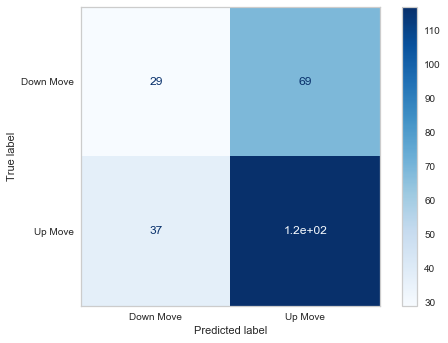

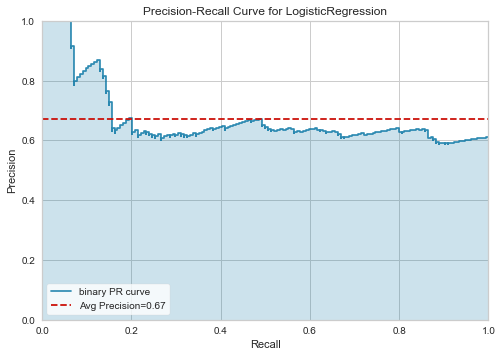

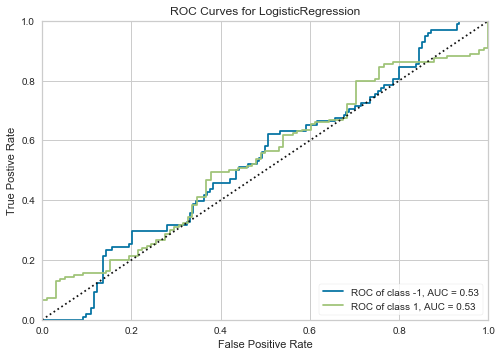


	KNN Mahalanobis

Precision Test Set: 0.70
Recall Test Set: 0.47


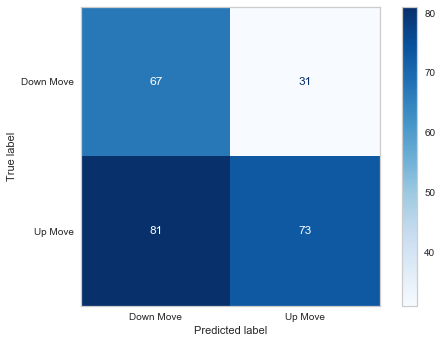

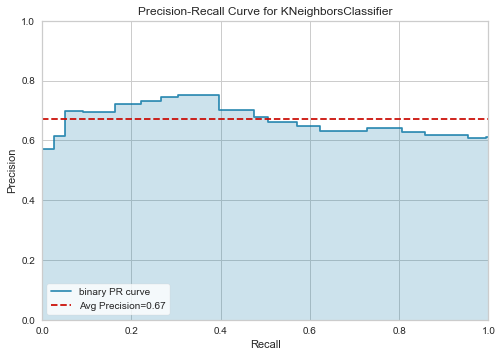

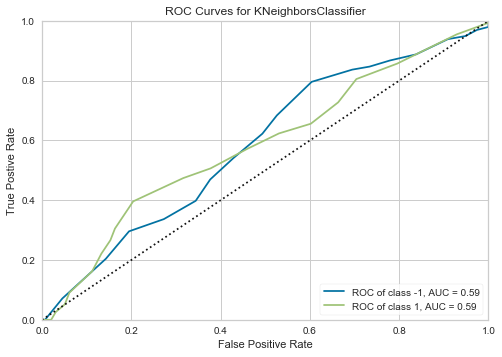


		Analyzing LOW

	Logistic Regression L2

Precision Test Set: 0.82
Recall Test Set: 0.39


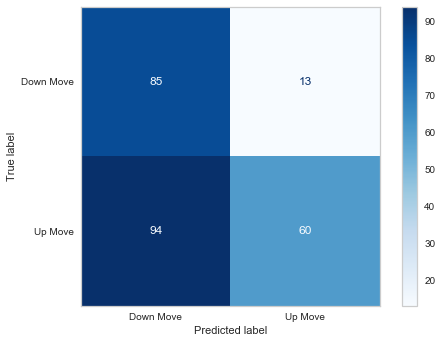

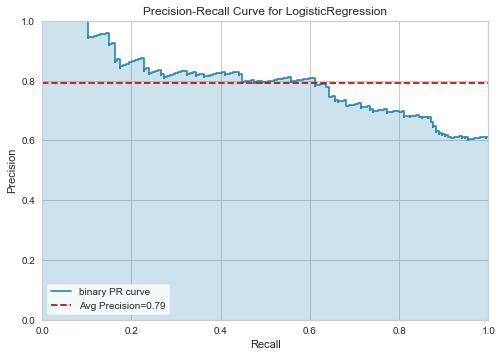

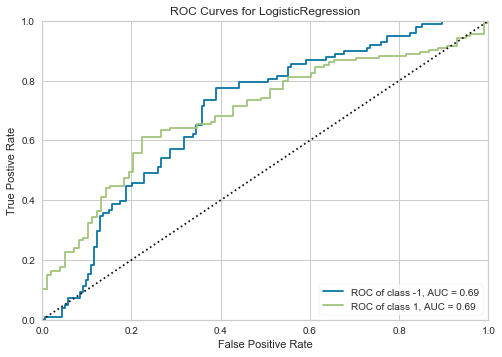


	KNN Mahalanobis

Precision Test Set: 0.64
Recall Test Set: 0.55


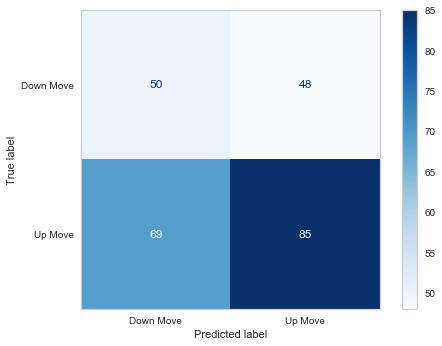

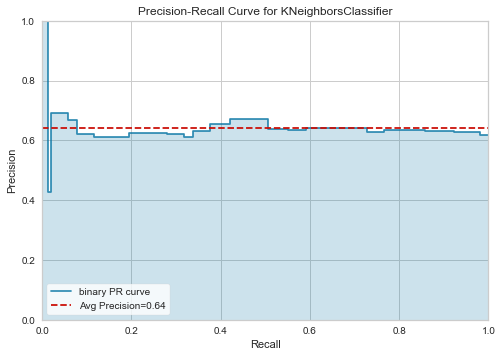

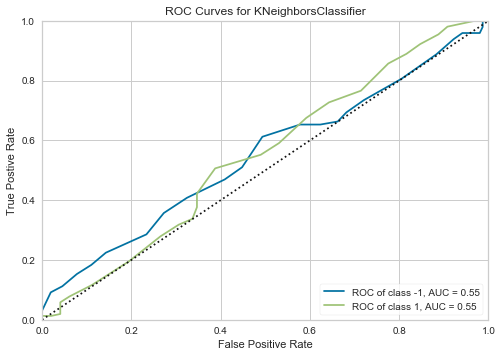

In [26]:
# Estimators Chosen: Logistic Regression L2 and KNN Mahalanobis (Plotting Metrics)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

classifiers = {0:'Logistic Regression L2',3:'KNN Mahalanobis'}

for stock_name, stock in stocks.items():
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    
    for index, classifier_name in classifiers.items():
        print ("\n\033[1m\033[4m\t{}\033[0m\033[0m\n".format(classifier_name))
        clf = bestClassifiers[stock_name][index]
        plotMetrics(clf, X_train_scaled, y_train, X_test_scaled, y_test, list(target_names.values()))

---
### Scatter Plot of Transitional Probabilities

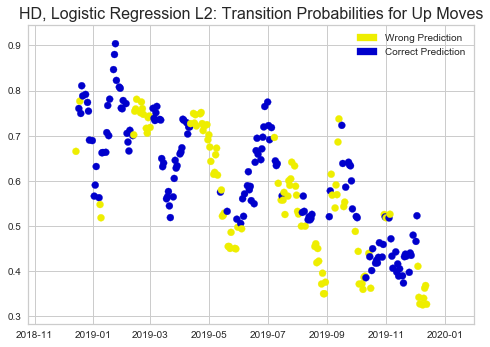

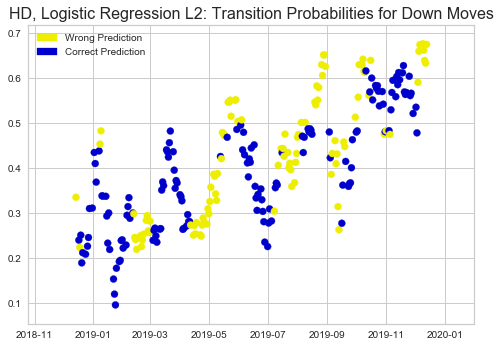

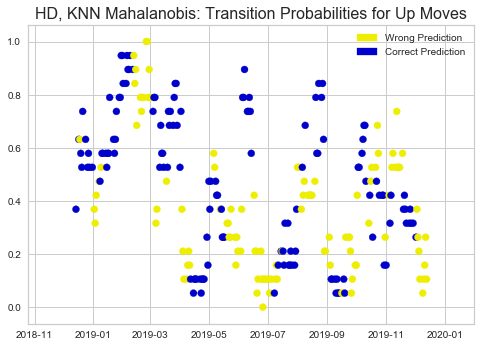

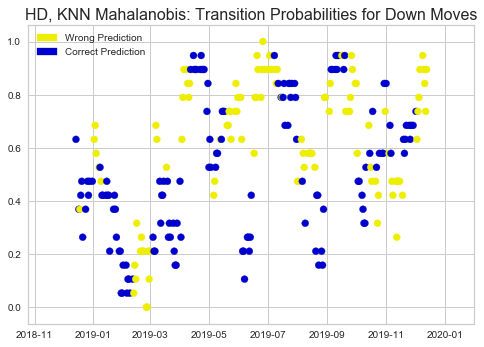

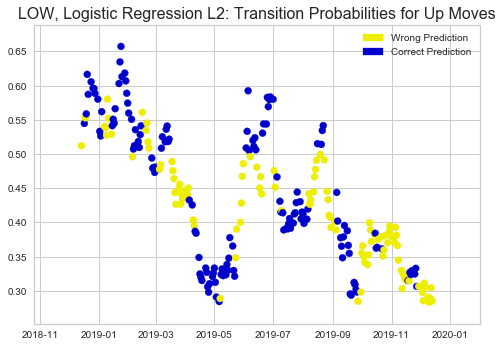

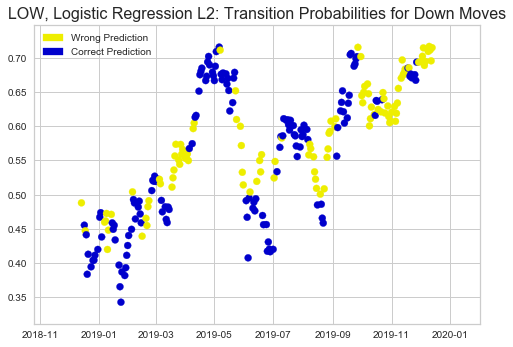

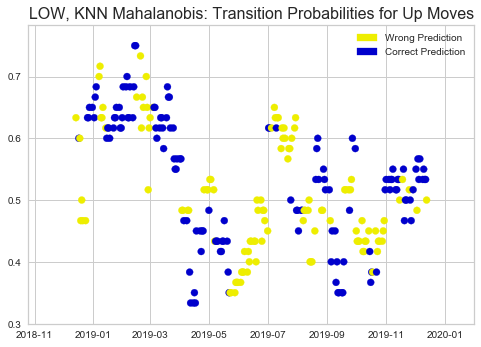

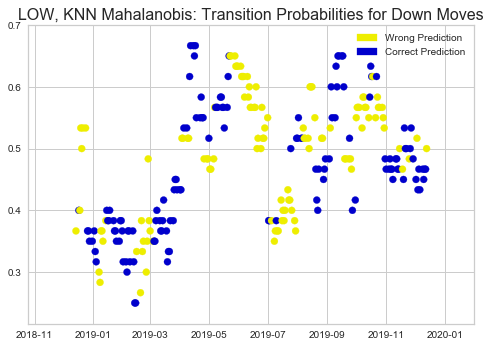

In [27]:
# Estimators Chosen: Logistic Regression L2 and KNN Mahalanobis (Plotting Transitional Probabilities)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

classifiers = {0:'Logistic Regression L2',3:'KNN Mahalanobis'}

for stock_name, stock in stocks.items():
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    
    for index, classifier_name in classifiers.items():
        clf = bestClassifiers[stock_name][index]
        title = stock_name + ', '+classifier_name
        plotTransitionProb(clf,stock,X_test_scaled,y_test,title = title, testSize = 252)

---
### Calculating Daily Returns

1. The classifiers performance are similar in case of boh the stocks. KNN Classifier gives better results than Logisitc Regression.
2. Higher Returns observed in HD stock for both the classifiers as compared to LOW Stock are due to superior returns in HD stock over 2019.


		Analyzing HD

Logistic Regression L2
Total Annual Return: 67.37 %

KNN Mahalanobis
Total Annual Return: 88.43 %

		Analyzing LOW

Logistic Regression L2
Total Annual Return: 25.34 %

KNN Mahalanobis
Total Annual Return: 35.10 %


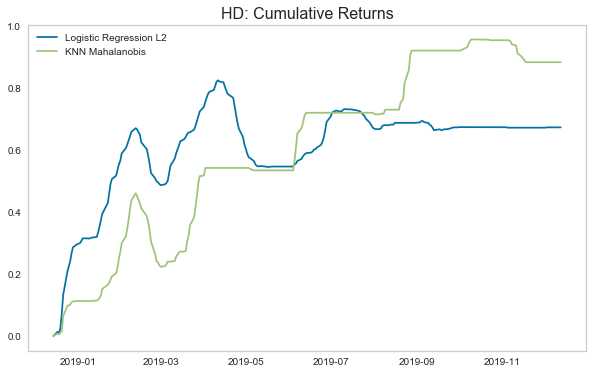

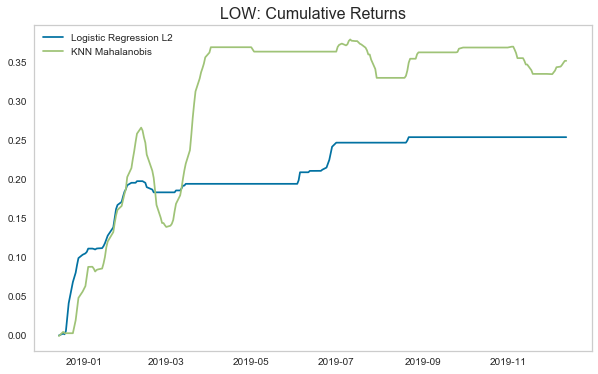

In [28]:
# Calculating Daily Returns (Task B.3)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

dailyPnL = {'HD':[],'LOW':[]}

classifiers = {0:'Logistic Regression L2',3:'KNN Mahalanobis'}

for stock_name, stock in stocks.items():
    print ("\n\033[1m\t\t\033[4mAnalyzing {}\033[0m\033[0m".format(stock_name))
    X_train, X_test, y_train, y_test = createTrainTest(stock, features)
    X_train_scaled, X_test_scaled = scaleTrainTest(X_train, X_test)
    
    for index, classifier_name in classifiers.items():
        print ("\n\033[1m\033[4m{}\033[0m\033[0m".format(classifier_name))
        clf = bestClassifiers[stock_name][index]
        threshold = 0.52
        seriesPandL, profit = calcPnL(clf,stock,X_test_scaled,y_test,threshold = threshold)
        dailyPnL[stock_name].append(seriesPandL)
        print ("Total Annual Return: {:.2f} %".format(profit))

for stock_name in stocks.keys():
    plt.figure(figsize=(10,6))
    for i,classifier_name in enumerate(classifiers.values()):
        plt.plot(dailyPnL[stock_name][i].cumsum(),label=classifier_name)
    plt.legend()
    plt.title('{}: Cumulative Returns'.format(stock_name),fontdict = {'fontsize':16})
    plt.grid(False)

<hr style="border:.05px solid black"><br>